In [16]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from pybedtools import BedTool
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy.spatial.distance import pdist, squareform
from plot_params import *
import numpy as np
basedir= Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'
#fl='/home/hsher/scratch/K562_rep4.count.csv'

In [2]:
ground_truth = pd.read_csv('Dan_multiplex1_K562_rep4.Dan_multiplex1_K562_rep6.reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [3]:
data = pd.read_csv(basedir/f'DMM/{out_stem}.mixture_weight.tsv', sep = '\t', index_col = 0)
data.set_index('Row.names', inplace = True)
#data_rand = pd.read_csv(basedir/f'delta.rr.tsv', sep = '\t', index_col = 0)

In [4]:
mixture_weight_only = data.loc[:, data.columns.str.startswith('V')]
mixture_weight_only.columns
data['cluster']=mixture_weight_only.idxmax(axis = 1)

In [5]:
mapstat = pd.read_csv(basedir/'QC/mapping_stats.csv')
mapstat = mapstat.loc[mapstat['STAR Log filename'].str.contains(out_stem)]
mapstat['name'] = mapstat['STAR Log filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
mapstat.set_index('name', inplace = True)
mapstat['total_mapped_reads'] = mapstat['Uniquely mapped reads number']+mapstat['Number of reads mapped to multiple loci']

In [6]:
raw_data = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
raw_data = raw_data.loc[raw_data.sum(axis = 1)>10]
raw_data.index = raw_data.index+1

In [7]:

weights = pd.read_csv(basedir/f'DMM/{out_stem}.weights.tsv', sep = '\t', index_col = 0)
weights.index = [f'V{i}' for i in weights.index]

In [8]:
# apply mask to BBM, skipper and Piranha in place, not integrated into pipeline yet
mask = pd.read_csv(basedir / f'mask/{out_stem}.genome_mask.csv') 

In [9]:
megaoutput = pd.read_csv(basedir/f'DMM/{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)

In [10]:
megaoutput_unmask = pd.read_csv(basedir/f'DMM/{out_stem}.megaoutputs_unmasked.tsv',
                               sep = '\t', index_col = 0)

<Axes: >

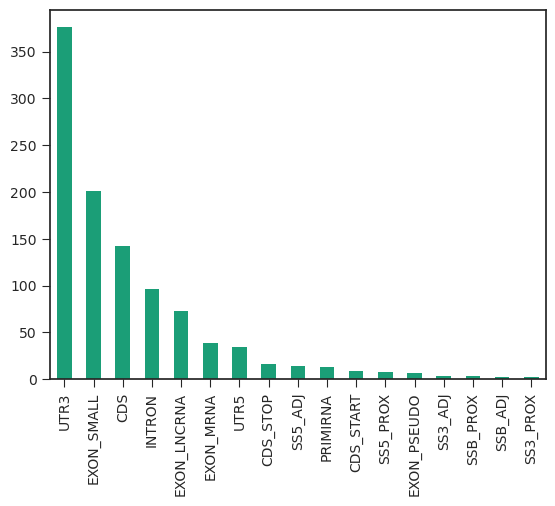

In [11]:
megaoutput_unmask.loc[megaoutput_unmask[f'{out_stem}.PUM2'], 'feature_type_top'
                     ].value_counts().plot.bar(stacked = True)

In [14]:
anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

In [17]:
# posterior odds
posterior = megaoutput[anno.loc[anno['K562_rep6.FAM120A']].index].sum(axis = 1)
megaoutput['FAM120A_posterior_odds'] = np.log(posterior/(1-posterior))

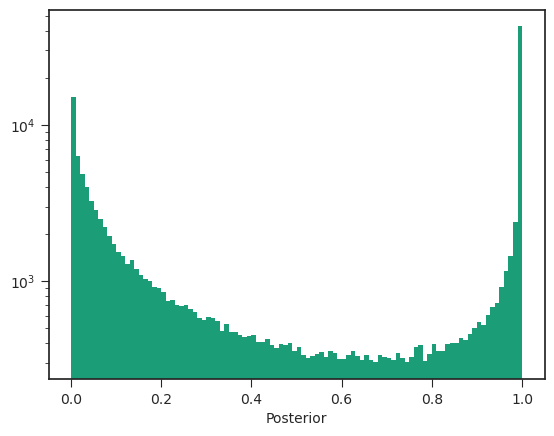

In [18]:
plt.hist(posterior, bins = 100)
plt.xlabel('Posterior')
plt.yscale('log')

# Supervised labelling

In [20]:
def compare_cluster_to_ground_truth(data, ground_truth, filter_thres = None):
    
    
    
    cluster_identity = data.idxmax(axis = 1)
    if filter_thres:
        confident_cluster = data.loc[data.max(axis = 1)>filter_thres].index
        cluster_identity = cluster_identity.loc[confident_cluster]
    
    # count window and ground truth
    count_df = []
    for cluster in cluster_identity.unique():
        indices = cluster_identity[cluster_identity==cluster].index

        counts = ground_truth.loc[ground_truth.index.isin(indices)].sum(axis = 0)
        counts['cluster_size'] = len(indices)
        counts['cluster_id'] = cluster
        count_df.append(counts)
        
    count_df = pd.DataFrame(count_df)
    count_df.set_index('cluster_id', inplace = True)
    
    # positive rate per cluster
    pos_rate = count_df.loc[:, count_df.columns[:-1]].div(count_df['cluster_size'], axis = 0)
        
    # total peaks in ground truth
    sum_peaks = ground_truth.sum(axis = 0)
    total_captured = count_df.loc[:, count_df.columns[:-1]].div(sum_peaks, axis = 1)
    
    return pos_rate, total_captured
    
    

Index([], dtype='object', name='cluster_id') is all 0


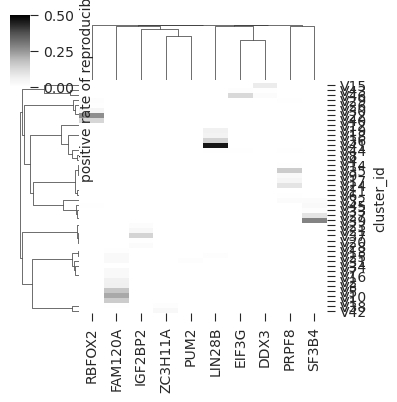

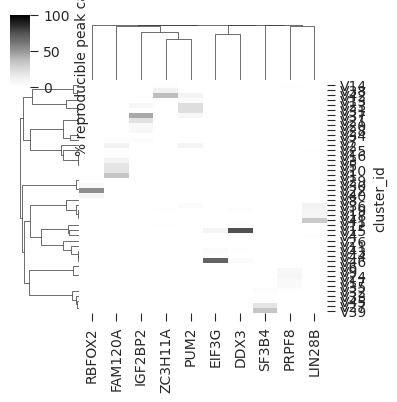

In [21]:
pos_rate, total_captured = compare_cluster_to_ground_truth(mixture_weight_only, ground_truth)
print(pos_rate.loc[pos_rate.sum(axis = 1)==0].index, 'is all 0')
pos_rate = pos_rate.loc[pos_rate.sum(axis = 1)>0]
total_captured = total_captured.loc[total_captured.sum(axis = 1)>0]
sns.clustermap(pos_rate, cbar_kws = {'label': 'positive rate of reproducible windows'},
              metric = 'cosine', cmap = 'Greys', figsize = (4,4), yticklabels = 1, vmax = 0.5)

sns.clustermap(total_captured*100, cbar_kws = {'label': '% reproducible peak captured'},
              metric = 'cosine', cmap = 'Greys', figsize = (4,4), yticklabels = 1, vmax = 100)

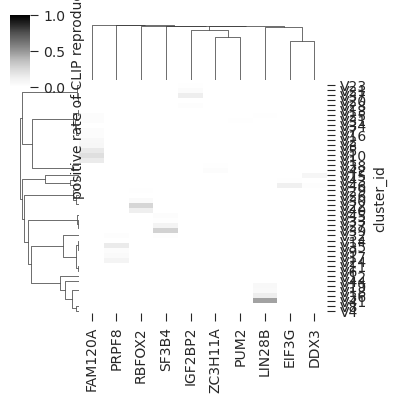

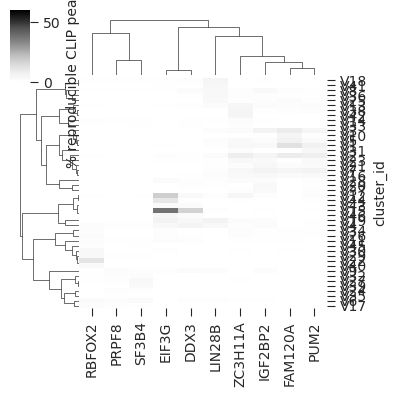

In [22]:
pos_rate_kmn, total_captured = compare_cluster_to_ground_truth(mixture_weight_only, ground_truth_skipper)

sns.clustermap(pos_rate, cbar_kws = {'label': 'positive rate of CLIP reproducible windows'},
              metric = 'correlation', cmap = 'Greys', figsize = (4,4), yticklabels = 1, vmax = 1)

sns.clustermap(total_captured*100, cbar_kws = {'label': '% reproducible CLIP peak captured'},
              metric = 'correlation', cmap = 'Greys', figsize = (4,4), yticklabels = 1, vmax = 60)

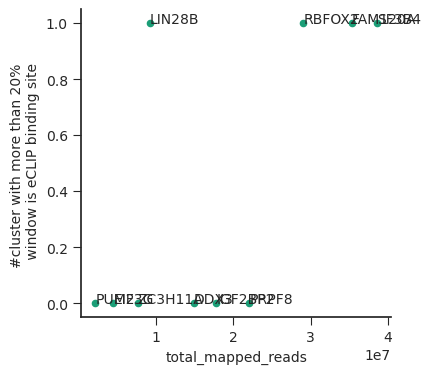

In [23]:
import matplotlib.pyplot as plt
mapped_reads_n_cluster = pd.concat([pos_rate.ge(0.2).sum(axis = 0), mapstat['total_mapped_reads']], axis = 1)
mapped_reads_n_cluster.plot.scatter(
    x = 'total_mapped_reads', y = 0, figsize = (4,4))
plt.ylabel('#cluster with more than 20% \n window is eCLIP binding site')

for index, row in mapped_reads_n_cluster.iterrows():
    plt.text(row['total_mapped_reads'], row[0], index)
sns.despine()



# Unsupervised labelling
## model weights

In [24]:

model_alphas = pd.read_csv(basedir/f'DMM/{out_stem}.alpha.tsv', sep = '\t',
                          index_col = 0) # RBP by components, B * K
model_mean = model_alphas.div(model_alphas.sum(axis = 0), axis = 1)
from scipy.stats import dirichlet
model_var = model_alphas.apply(lambda column: dirichlet(column).var(), axis = 0)



In [25]:
def params_groupby_posrate(model_params, pos_rate, label):
    ''' use eclip (pos_rate) labels and see mean/std difference '''
    f, axes = plt.subplots(2,5, figsize = (10,4))
    axes = axes.flatten()
    i = 0
    for index, row in model_params.iterrows():
        rbp = index.split('.')[1]
        is_eclip_cluster = pos_rate[rbp][pos_rate[rbp].ge(0.2)].index
        #print(is_eclip_cluster, row)
        is_real_cluster = row.loc[row.index.isin(is_eclip_cluster)]
        not_real_cluster = row.loc[~row.index.isin(is_eclip_cluster)]
        
        axes[i].boxplot([is_real_cluster, not_real_cluster])
        axes[i].set_title(rbp)
        axes[i].set_ylabel(label)
        axes[i].set_xticklabels(['contain_eCLIP', 'not'])
        i+=1
    sns.despine()


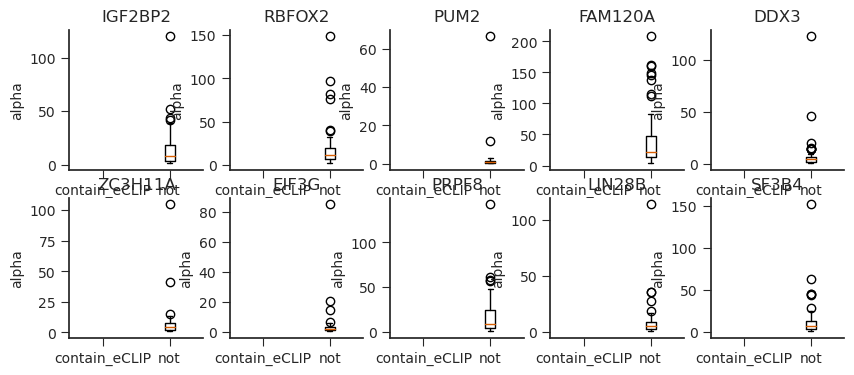

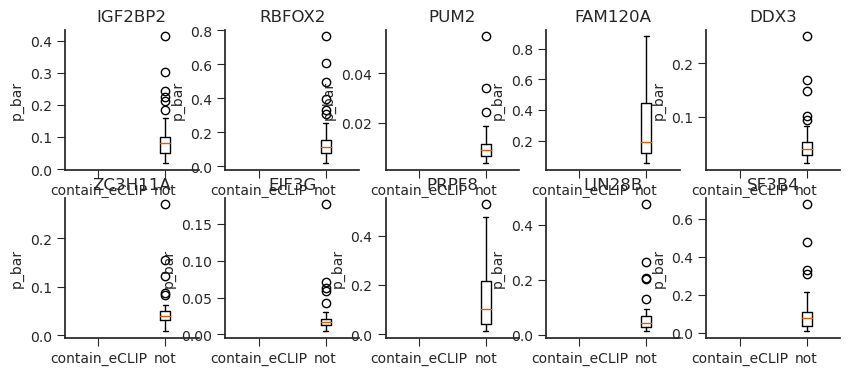

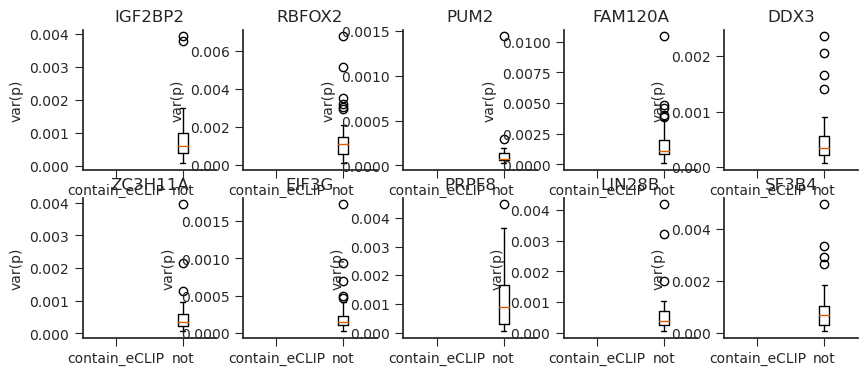

In [26]:
params_groupby_posrate(model_alphas, pos_rate_kmn, 'alpha')
params_groupby_posrate(model_mean, pos_rate_kmn, 'p_bar')
params_groupby_posrate(model_var, pos_rate_kmn, 'var(p)')


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8 ) missing from current font.
  func(*args, **kwargs)
/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


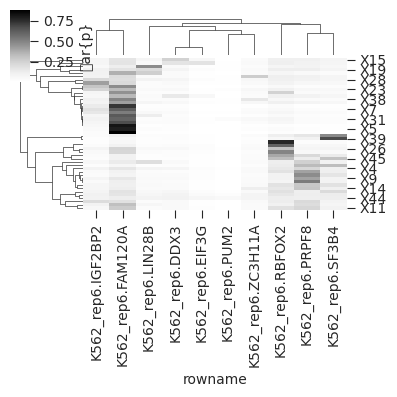

In [27]:
sns.clustermap(model_mean.T,
               cbar_kws = {'label': '\bar{p}'},
              metric = 'correlation', cmap = 'Greys', figsize = (4,4))

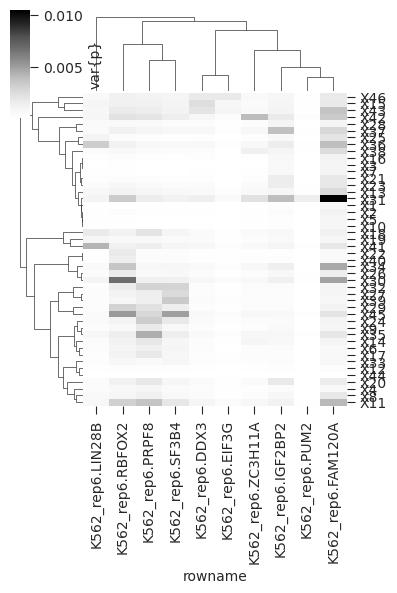

In [28]:
sns.clustermap(model_var.T,
               cbar_kws = {'label': 'var{p}'},
              metric = 'correlation', cmap = 'Greys', figsize = (4,6), yticklabels = 1)

# Cluster labelling benchmark: compare to eCLIP

In [29]:
read_count_mean = raw_data.sum().div(raw_data.sum().sum())
alpha_scaled = model_mean['X27'].sort_values()
visvalue = pd.concat([read_count_mean, alpha_scaled], axis = 1)

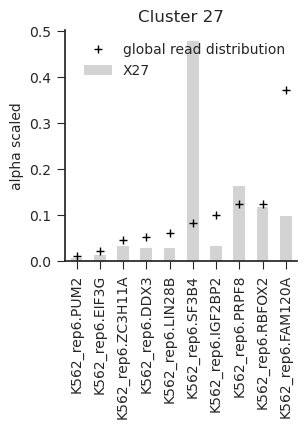

In [30]:
visvalue.sort_values(by = 0, inplace = True)
visvalue['X27'].plot.bar(figsize = (3,3), color = 'lightgrey')
for i,mean in enumerate(visvalue[0].tolist()):
    if i==9:
        plt.plot(i, mean, '+', color = 'black', label = 'global read distribution')
    else:
        plt.plot(i, mean, '+', color = 'black')
sns.despine()
plt.ylabel('alpha scaled')
plt.title('Cluster 27')
plt.legend()
plt.savefig(figdir/'cluster_label_example.pdf')


Text(0, 0.5, 'alpha scaled')

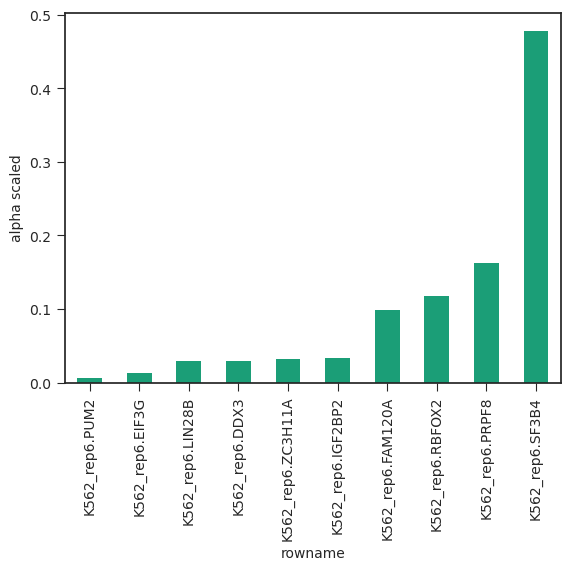

In [31]:
model_mean['X27'].sort_values().plot.bar()
plt.ylabel('alpha scaled')

In [32]:
import numpy as np
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import math

In [33]:
anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

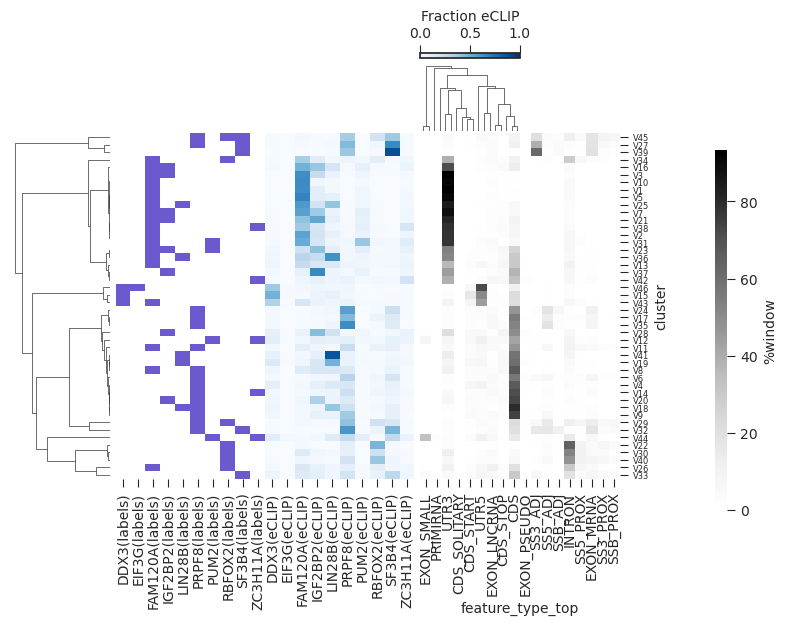

In [42]:
# idxmax from E[z_ik]

col = 'feature_type_top'
cluster_count = data.pivot_table(index = 'cluster', columns = col, 
                            fill_value=0, aggfunc='size')
cluster_frac = cluster_count.div(cluster_count.sum(axis = 1), axis = 0)

# annotation
anno_as_color = anno.applymap(lambda ans: 'slateblue' if ans else 'white')
anno_as_color.columns = [c.split('.')[1]+'(labels)' for c in anno_as_color.columns]

# eCLIP as gold standard
minima = 0
maxima = 1

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

rcolor = pos_rate_kmn.applymap(lambda value: mapper.to_rgba(value))
rcolor.columns = [c+'(eCLIP)' for c in rcolor.columns]

all_annotation = pd.concat([rcolor, anno_as_color], axis = 1).T.sort_index().T
                                 
cp=sns.clustermap(cluster_frac*100,
              cmap = 'Greys', metric = 'cosine', cbar_kws ={'label': '%window', }, 
                  cbar_pos = (1.2,0.2,0.02,0.6),
              figsize = (6,6), xticklabels = 1, yticklabels = 1,
              row_colors = pd.concat([anno_as_color.T.sort_index().T, rcolor.T.sort_index().T], axis = 1)
              )

hm = cp.ax_heatmap.get_position()
plt.setp(cp.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
cp.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*2, hm.height])
col = cp.ax_col_dendrogram.get_position()
cp.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*2, col.height*0.5])


plt.colorbar(mapper, ax = cp.ax_col_dendrogram, orientation='horizontal',
            location = 'top',  label='Fraction eCLIP')
plt.savefig(figdir/'cluster_label.pdf')
# sns.clustermap(cluster_frac*100,
#               cmap = 'Greys', metric = 'cosine', cbar_kws ={'label': '%window', }, cbar_pos = (1,0.2,0.02,0.6),
#               figsize = (6,6), xticklabels = 1, yticklabels = 1,
#               row_colors =  rcolor.T.sort_index().T)


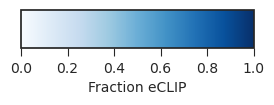

In [36]:
f, ax = plt.subplots(figsize = (3,0.5))
plt.colorbar(mapper, cax = ax, orientation='horizontal', label='Fraction eCLIP')
plt.savefig(figdir/'cluster_label_cbar.pdf')

# Compare binding site classification to eCLIP
## By unique hypothesis
compare to beta-mixutre, clipper

In [27]:
def read_piranha_pv():
    indir = basedir / 'comparison' / 'piranha' / 'CC'
    count = []
    for f in list(indir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        
        cnt = 1-piranha_df.set_index('name')['pval']
        cnt.name = f.name.split('.')[1]
        count.append(cnt)
    return pd.concat(count, axis = 1).T

In [28]:
def read_beta_mixture_results(folder = 'beta-mixture_CC'):
    enrich_type_count = []
    window_score = []
    for f in list((basedir / folder).glob(f'{out_stem}*enriched_windows.tsv')):
        rbp = f.name.split('.')[1]
        enriched_features = pd.read_csv(f, sep = '\t')
        feature_types = enriched_features['feature_type_top'].value_counts()
        feature_types.name = rbp
        enrich_type_count.append(feature_types)

        full_scores = pd.read_csv(str(f).replace('enriched_windows', 'window_score'), sep = '\t').set_index('name')
        if 'logLR' in full_scores.columns:
            score = full_scores['logLR']
        else:
            score = 1-full_scores['pvalue']
        score.name = rbp
        window_score.append(score)

    enrich_type_count = pd.concat(enrich_type_count, axis = 1).fillna(0).T
    beta_score = pd.concat(window_score, axis = 1)
    beta_score = beta_score.merge(data['cluster'], left_index = True, right_index = True, how = 'right').fillna(0)

    
    return enrich_type_count, beta_score


In [29]:
enrich_type_count, beta_score = read_beta_mixture_results('beta-mixture_CC')
enrich_type_count_smi, beta_score_smi = read_beta_mixture_results('beta-mixture_external/eCLIP_SLBP_SMInput')
enrich_type_count_rnaseq, beta_score_rnaseq = read_beta_mixture_results('beta-mixture_external/K562_totalRNAseq')
enrich_type_count_bead, beta_score_bead = read_beta_mixture_results('beta-mixture_external/oligoCLIP_ctrlBead_rep1')
enrich_type_count_spike, beta_score_spike = read_beta_mixture_results('beta-mixture_external/oligoCLIP_ctrlSpike_rep1')
enrich_type_count_igg, beta_score_igg = read_beta_mixture_results('beta-mixture_external/oligoCLIP_IgG_rep1')

In [30]:
# beta-mixture results

# CLIPper
clipper_pv = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_pval_perwindow.csv', index_col = 0)
clipper_pv = clipper_pv.merge(data['cluster'], left_index = True, right_index = True, how = 'right').fillna(0) # some had missing windows, no clipper peaks. fill w 0
clipper_fc = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_fc_perwindow.csv', index_col = 0)
clipper_fc = clipper_fc.merge(data['cluster'], left_index = True, right_index = True, how = 'right').fillna(0)



In [31]:
piranha_pv = read_piranha_pv().fillna(0).T
piranha_pv = piranha_pv.merge(data['cluster'], left_index = True, right_index = True, how = 'right').fillna(0)


In [32]:
# make sure they are of the same shape
ground_truth_skipper10reads = ground_truth_skipper.loc[ground_truth_skipper.index.isin(data.index)]
ground_truth_skipper10reads = ground_truth_skipper10reads.merge(data, left_index = True, right_index = True, how = 'right')[ground_truth_skipper.columns].fillna(False)

In [33]:
clipper_pv.shape, clipper_fc.shape, ground_truth_skipper.shape, data.shape, piranha_pv.shape

((138498, 11), (138498, 11), (232922, 10), (138498, 63), (138498, 11))

In [34]:
def collapsed_gold_standard(cluster_assignment_df, ground_truth_skipper):
    '''
    generate gold standard per hypothesis (type of label)
    returns:
        gold_collapse: collapsed goldstandard per hypothesis
        collapsed_cluster: dict, hypothesis -> component
        collapsed_cluster_anno: dict, hypothesis -> RBPs that are positive
    '''
    cluster_gold_standard_collapsed = []
    collapsed_cluster = {}
    collapsed_cluster_annot = {}

    id_ = 0
    for name, group in cluster_assignment_df.groupby(by = cluster_assignment_df.columns.tolist()):
        columns = group.columns[group.sum(axis = 0)>0]
        if len(columns) > 0:
            cluster_ids = group.index
            collapsed_cluster[id_]=cluster_ids

            columns = group.columns[group.sum(axis = 0)>0]

            rbps = [r.split('.')[1] for r in
                    columns]
            collapsed_cluster_annot[id_]=rbps
            truth = (ground_truth_skipper[rbps].all(axis = 1))&(ground_truth_skipper.sum(axis = 1).eq(len(rbps)))

            truth.name = id_
            cluster_gold_standard_collapsed.append(truth)
            id_ += 1
    cluster_gold_standard_collapsed = pd.concat(cluster_gold_standard_collapsed, axis = 1)
    cluster_gold_standard_collapsed[cluster_gold_standard_collapsed.sum(axis = 0).sort_values(ascending = False).index]
    return cluster_gold_standard_collapsed, collapsed_cluster, collapsed_cluster_annot

In [35]:
def collapsed_posterior(data, collapsed_cluster):
    ''' sum of posterior P(is cluster | data) for cluster of the same type of hypothesis '''
    collapsed_data = []
    for hypothesis in collapsed_cluster.keys():
        sum_score = data[collapsed_cluster[hypothesis]].sum(axis = 1)
        sum_score.name = hypothesis
        collapsed_data.append(sum_score)
    return pd.concat(collapsed_data, axis = 1)

In [36]:
# common index
def collapsed_auprc(cluster_gold_standard_collapsed, collapsed_data, collapsed_cluster, collapsed_cluster_annot,
                   clipper_pv = clipper_pv, clipper_fc = clipper_fc, beta_score = beta_score):
    auprc_data = []
    
    com_index = cluster_gold_standard_collapsed.index
    # plot ROC curve
    f, axes = plt.subplots(4, int(cluster_gold_standard_collapsed.shape[1]/4), figsize = (12,8))
    axes = axes.flatten()
    for col, ax in zip(cluster_gold_standard_collapsed.columns, axes):
        
        clusters_ids = collapsed_cluster[col]
        rbps = collapsed_cluster_annot[col]
        # mixture scores
        score = collapsed_data.loc[com_index, col]
        
        # clipper
        clipper_pv_score = clipper_pv.loc[com_index, rbps].sum(axis = 1)
        clipper_fc_score = clipper_fc.loc[com_index, rbps].sum(axis = 1)
        beta_sum_score = beta_score.loc[com_index, rbps].sum(axis = 1)
        
        # eCLIP as ground truth                          
        truth = cluster_gold_standard_collapsed.loc[com_index, col]
        
        # DMM
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                score)
        ax.plot(recall, precision, label = 'DMM E[z_ik]')
        dmm_auprc = auc(recall, precision)
        
        # Beta-mixture
        
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                beta_sum_score)
        ax.plot(recall, precision, label = 'Beta-Mixture')
        beta_auprc = auc(recall, precision)
        
        # clipper
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                clipper_pv_score)
        ax.plot(recall, precision, label = 'CLIPper(p-value)')
        pv_auprc = auc(recall, precision)
        
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                clipper_fc_score)
        ax.plot(recall, precision, label = 'CLIPper(FC)')
        fc_auprc = auc(recall, precision)
        
        
        
        
        rbp_str = ','.join(rbps)
        ax.set_title(f'Hypothesis {col}\n({rbp_str})')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        
        auprc_data.append([col, rbp_str, dmm_auprc, beta_auprc, pv_auprc, fc_auprc])
    ax.legend()
    sns.despine()
    plt.tight_layout()
    return pd.DataFrame(auprc_data, columns=['Hypothesis No.', 'RBP', 'DMM', 'Beta', 'CLIPper pvalue', 'CLIPper FC'])

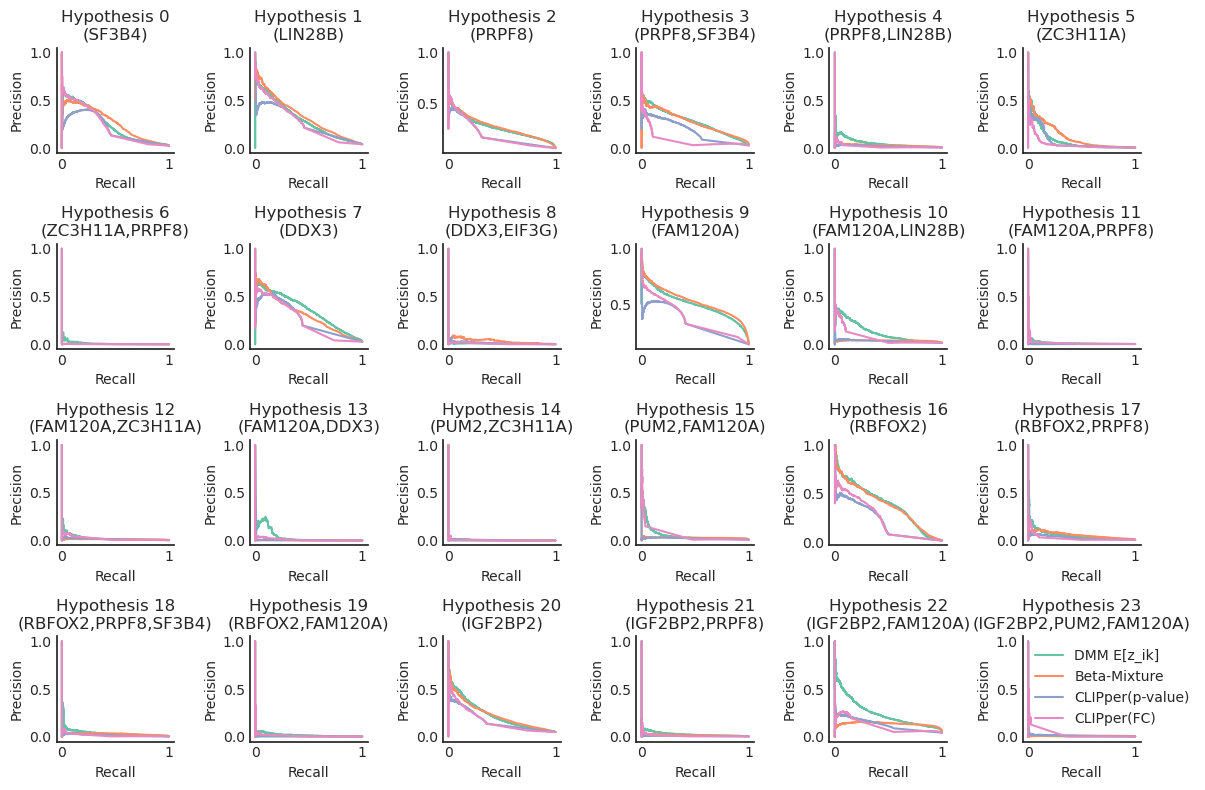

In [37]:
sns.set_palette('Set2')
gold_collapse, collapsed_cluster, collapsed_cluster_anno = collapsed_gold_standard(anno, ground_truth_skipper10reads)
collapsed_data = collapsed_posterior(data, collapsed_cluster)
collapsed_beta = collapsed_posterior(beta_score, collapsed_cluster_anno)
collapsed_clipper_pv = collapsed_posterior(clipper_pv, collapsed_cluster_anno)
collapsed_clipper_fc = collapsed_posterior(clipper_fc, collapsed_cluster_anno)

auprc_df = collapsed_auprc(gold_collapse, collapsed_data, collapsed_cluster, collapsed_cluster_anno)
plt.savefig(figdir/'Hypothesis_AUPRC.pdf')

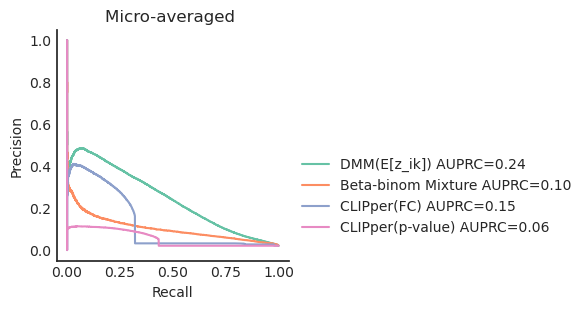

In [38]:
# microaverage precision recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
com_index = collapsed_data.index

# For each class
y_score = collapsed_data
Y_test = gold_collapse
precision = dict()
recall = dict()
average_precision = dict()
f, ax = plt.subplots(figsize = (3,3))

for y_score, name in zip([collapsed_data, collapsed_beta, collapsed_clipper_fc, collapsed_clipper_pv],
                         ['DMM(E[z_ik])', 'Beta-binom Mixture', 'CLIPper(FC)', 'CLIPper(p-value)']
                        ):
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.loc[com_index].values.ravel(), y_score.loc[com_index].values.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test.loc[com_index], y_score.loc[com_index], average="micro")
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    auprc = auc(recall["micro"], precision["micro"])
    display.plot(label = f'{name} AUPRC={auprc:.2f}', ax = ax)
    _ = display.ax_.set_title("Micro-averaged ")
ax.legend(bbox_to_anchor = (1, 0.5))
sns.despine()
plt.savefig(figdir/'Hypothesis_micro_AUPRC.pdf')

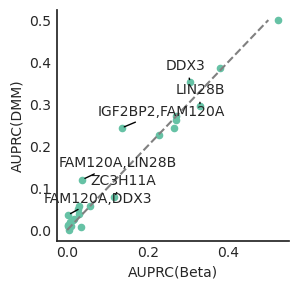

In [39]:
col1 = 'Beta'
col2 = 'DMM'
auprc_df.plot.scatter(x = col1, y = col2,figsize = (3,3))
plt.plot([0,auprc_df['DMM'].max()],[0,auprc_df['DMM'].max()], '--', color = 'grey')
for index, row in auprc_df.loc[(auprc_df[col1]-auprc_df[col2]).abs()>0.03].iterrows():
    plt.annotate(row['RBP'],(row[col1], row[col2]),xytext=(row[col1]-0.06, row[col2]+0.03),
                arrowprops=dict(arrowstyle= '-',))
sns.despine()
plt.xlabel(f'AUPRC({col1})')
plt.ylabel(f'AUPRC({col2})')
plt.savefig(figdir/f'AUPRC_scatter.{col1}vs{col2}.pdf')

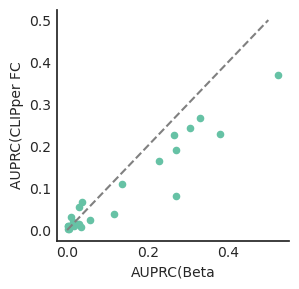

In [40]:
col1 = 'Beta'
col2 = 'CLIPper FC'
auprc_df.plot.scatter(x = col1, y = col2,figsize = (3,3))
plt.plot([0,auprc_df['DMM'].max()],[0,auprc_df['DMM'].max()], '--', color = 'grey')
# for index, row in auprc_df.loc[(auprc_df[col1]-auprc_df[col2]).abs()>0.03].iterrows():
#     plt.annotate(row['RBP'],(row[col1], row[col2]),xytext=(row[col1]-0.06, row[col2]+0.03),
#                 arrowprops=dict(arrowstyle= '-',))
sns.despine()
plt.xlabel(f'AUPRC({col1}')
plt.ylabel(f'AUPRC({col2}')
plt.savefig(figdir/f'AUPRC_scatter.{col1}vs{col2}.pdf')

In [41]:
(auprc_df['DMM']-auprc_df['CLIPper FC']).mean()

0.04711420954434339

In [42]:
(auprc_df['DMM']-auprc_df['Beta']).mean()

0.009148500596494224

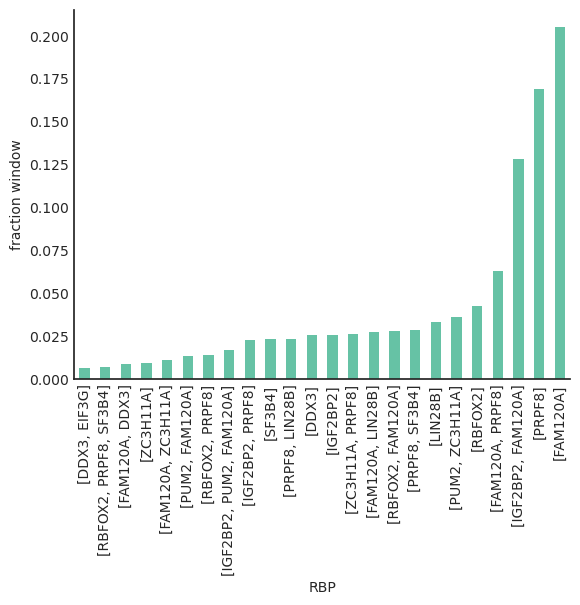

In [43]:
hypothesis_size = pd.Series(collapsed_cluster).apply(lambda clusters: weights.loc[clusters].sum())
hypothesis_size['RBP']=hypothesis_size.index.map(collapsed_cluster_anno)
hypothesis_size.set_index('RBP')['pi'].sort_values().plot.bar()
plt.ylabel('fraction window')
sns.despine()

## Binary classification: Whether is a binding site for 1 RBP

In [44]:
def get_mixture_score_by_rbp(cluster_assignment_df,data):
    ''' sum up mixture score by belonging to a RBP or not '''
    mixture_score_by_rbp = []
    for rbp in cluster_assignment_df:
        clusters_belong_to_rbp = cluster_assignment_df[rbp].loc[cluster_assignment_df[rbp]].index
        rbp_score = data[clusters_belong_to_rbp].sum(axis = 1)
        rbp_score.name = rbp.split('.')[1]
        mixture_score_by_rbp.append(rbp_score)
    mixture_score_by_rbp = pd.concat(mixture_score_by_rbp, axis = 1)
    return mixture_score_by_rbp

In [45]:
by_rbp = get_mixture_score_by_rbp(anno, data)

In [46]:
window_by_rbp_score = pd.DataFrame(np.matmul(mixture_weight_only.values, model_mean.T.values),
                                   index = mixture_weight_only.index,
                                   columns = model_mean.index)

In [47]:
def by_rbp_auprc(mixture_score_by_rbp, ground_truth_skipper, data, 
                 clipper_pv = clipper_pv, clipper_fc = clipper_fc, beta_score = beta_score,
                piranha_pv = piranha_pv, ):
    # common index
    com_index = list(set(ground_truth_skipper.index).intersection(set(data.index)))
    # plot ROC curve
    f, axes = plt.subplots(2,math.ceil(ground_truth_skipper.shape[1]/2), figsize = (12,4), 
                           sharex = True, sharey = True)
    axes = axes.flatten()
    auprc_data = []
    for col, ax in zip(mixture_score_by_rbp.columns, axes):
        truth = ground_truth_skipper.loc[com_index, col]
        
        
        # DMM
        score = mixture_score_by_rbp.loc[com_index, col]
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                score)
        
        ax.plot(recall, precision, label = 'DMM(E[z_ik])')
        dmm_auprc = auc(recall, precision)
        
        # Beta
        beta_s = beta_score.loc[com_index, col]
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                beta_s)
        ax.plot(recall, precision, label = 'Beta-Mixture(CC)')
        beta_auprc = auc(recall, precision)
        
        # CLIPper p-value
        pv_score = clipper_pv.loc[com_index, col]
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                pv_score)
        ax.plot(recall, precision, label = 'CLIPper(p-value)')
        pv_auprc = auc(recall, precision)
        
        # CLIPper p-value
        fc_score = clipper_fc.loc[com_index, col]
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                fc_score)
        ax.plot(recall, precision, label = 'CLIPper(FC)')
        fc_auprc = auc(recall, precision)
        
        # piranha p-value
        pi_score = piranha_pv.loc[com_index, col]
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                pi_score)
        ax.plot(recall, precision, label = 'Piranha(p-value)')
        pi_auprc = auc(recall, precision)
        
        auprcs = [col, dmm_auprc, beta_auprc, pv_auprc, fc_auprc, pi_auprc]
        names  = ['SMInput', 'total RNAseq', 'Bead', 'Spike-in', 'IgG']
        for background_beta_score, name in zip([beta_score_smi, beta_score_rnaseq, beta_score_bead, beta_score_spike,
                                                beta_score_igg],
                                               names
                                              ):
            pi_score = background_beta_score.loc[com_index, col]
            precision, recall, thresholds = precision_recall_curve(truth, 
                                                                    pi_score)
            ax.plot(recall, precision, label = name)
            beta_auprc = auc(recall, precision)
            auprcs.append(beta_auprc)
        
        ax.set_title(col)
        ax.set_ylabel('Recall')
        ax.set_xlabel('Precision')
        auprc_data.append(auprcs)
        
    ax.legend(bbox_to_anchor = (1.2, 0.4))
    sns.despine()
    plt.tight_layout()
    
    
    return pd.DataFrame(auprc_data, 
                        columns=['RBP', 'DMM', 'Beta', 'CLIPper pvalue', 'CLIPper FC', 'Piranha pvalue']
                       +names)

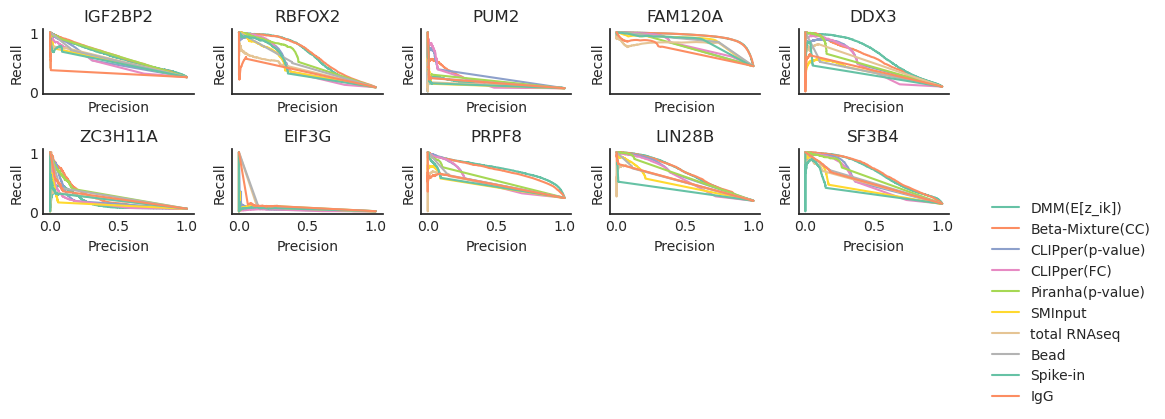

In [48]:
auprc_df_bybg = by_rbp_auprc(by_rbp, ground_truth_skipper, data)
plt.savefig(figdir/f'AUPRC_individual_wbg.pdf')

In [49]:
auprc_df_bybg['DMM'].ge(auprc_df_bybg['SMInput'])

0     True
1     True
2     True
3     True
4     True
5     True
6    False
7     True
8     True
9     True
dtype: bool

In [50]:
auprc_df_bybg['DMM'].ge(auprc_df_bybg['total RNAseq'])

0     True
1     True
2     True
3     True
4     True
5    False
6    False
7     True
8     True
9     True
dtype: bool

In [51]:
auprc_df_bybg['DMM'].ge(auprc_df_bybg['Bead'])

0     True
1     True
2    False
3     True
4     True
5    False
6    False
7     True
8     True
9     True
dtype: bool

In [52]:
auprc_df_bybg['DMM'].ge(auprc_df_bybg['Spike-in'])

0     True
1     True
2     True
3     True
4     True
5    False
6    False
7     True
8     True
9     True
dtype: bool

In [53]:
auprc_df_bybg['DMM'].ge(auprc_df_bybg['IgG'])

0     True
1     True
2    False
3     True
4     True
5    False
6    False
7     True
8     True
9     True
dtype: bool

In [54]:
auprc_df_bybg.set_index('RBP', inplace = True)

In [55]:
auprc_df_bybg.columns

Index(['DMM', 'Beta', 'CLIPper pvalue', 'CLIPper FC', 'Piranha pvalue',
       'SMInput', 'total RNAseq', 'Bead', 'Spike-in', 'IgG'],
      dtype='object')

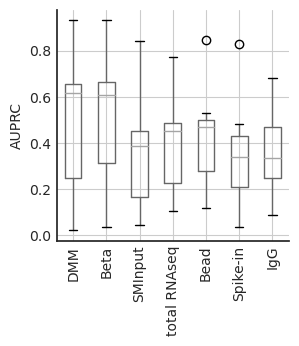

In [56]:
auprc_df_bybg[['DMM', 'Beta', 
       'SMInput', 'total RNAseq', 'Bead', 'Spike-in', 'IgG']].boxplot(rot = 90, figsize = (3,3))
sns.despine()
plt.ylabel('AUPRC')
plt.savefig(figdir / 'multiplex_external_library.pdf')

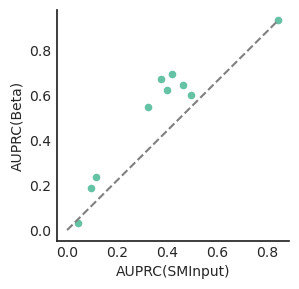

In [57]:
col2 = 'Beta'
col1 = 'SMInput'
auprc_df_bybg.plot.scatter(x = col1, y = col2,figsize = (3,3))
plt.plot([0,auprc_df_bybg[col1].max()],[0,auprc_df_bybg[col2].max()], '--', color = 'grey')
for index, row in auprc_df_bybg.loc[(auprc_df_bybg[col1]-auprc_df[col2]).abs()>0.03].iterrows():
    plt.annotate(row['RBP'],(row[col1], row[col2]),xytext=(row[col1]-0.06, row[col2]+0.03),
                arrowprops=dict(arrowstyle= '-',))
sns.despine()
plt.xlabel(f'AUPRC({col1})')
plt.ylabel(f'AUPRC({col2})')
plt.savefig(figdir/f'AUPRC_scatter.{col1}vs{col2}.pdf')

In [58]:
def single_rbp_auprc(col, mixture_score_by_rbp, ground_truth_skipper, data, 
                 clipper_pv = clipper_pv, clipper_fc = clipper_fc, beta_score = beta_score):
    # common index
    com_index = list(set(ground_truth_skipper.index).intersection(set(data.index)))
    # plot ROC curve
    f, ax = plt.subplots(1,1, figsize = (4,4), 
                           sharex = True, sharey = True)
    
    
    
    # DMM
    score = mixture_score_by_rbp.loc[com_index, col]
    truth = ground_truth_skipper.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'DMM AUPRC={auprc:.2f}')
    

    # Beta
    beta_s = beta_score.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            beta_s)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'Beta-Mixture AUPRC={auprc:.2f}')
    

    # CLIPper p-value
    pv_score = clipper_pv.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            pv_score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'CLIPper(p-value) AUPRC={auprc:.2f}')
    

    # CLIPper p-value
    fc_score = clipper_fc.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            fc_score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'CLIPper(FC), AUPRC={auprc:.2f}')
    



    ax.set_title(col)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    ax.legend(bbox_to_anchor = (0.5, 1))
    sns.despine()
    
    

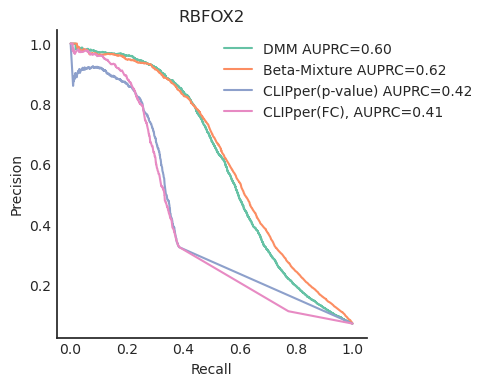

In [59]:
single_rbp_auprc('RBFOX2', by_rbp, ground_truth_skipper, data)

In [60]:
(auprc_df_bybg['DMM']-auprc_df_bybg['Beta']).mean()

-0.011015424929100365

In [61]:
(auprc_df_bybg['Beta']-auprc_df_bybg['CLIPper FC']).mean()

0.12209529515740707

In [62]:
(auprc_df_bybg['DMM']-auprc_df_bybg['CLIPper FC']).mean()

0.11107987022830672

In [63]:
(auprc_df_bybg['DMM']-auprc_df_bybg['Piranha pvalue']).mean()

0.05347150759706702

# RBP binding sites feature_distribution, compare to other algorithms (just with mixture weights)

In [64]:
def get_clipper_annotator(prefix = out_stem):
    clipper_annotator_count = []
    for f in Path(f'/tscc/projects/ps-yeolab5/ABC_chisq_peaks/Dan_multiplex1_{prefix}').glob('*.summary'):
        rbp = f.name.split('.')[0].split('_')[-1]
        df = pd.read_csv(f, comment = '#', index_col = 0)
        df = df.loc[df.index[(~df.index.str.contains('fraction'))&
                            (~df.index.str.contains('n_'))&
                             (~df.index.str.contains('filter'))&
                             (~df.index.str.contains('RNA'))&
                             (~df.index.str.contains('pseudogene'))
                            ]]

        df.columns = [rbp]
        if 'miRNA' in df.index:
            first_mirna = min([n for n, i in enumerate(df.index) if i == 'miRNA'])
            df = df.iloc[:first_mirna+1]
        clipper_annotator_count.append(df[rbp])

    clipper_annotator_count = pd.concat(clipper_annotator_count, axis = 1).fillna(0)
    # rename things
    clipper_annotator_count.rename({'3utr':'UTR3', '5utr': 'UTR5',
                                   'stop_codon':'CDS_STOP',
                                   'noncoding_exon':'EXON_SMALL'}, inplace = True)
    clipper_annotator_count = clipper_annotator_count.T
    clipper_annotator_count['INTRON'] = clipper_annotator_count['distintron500']+clipper_annotator_count['distnoncoding_intron500']
    clipper_annotator_count['SSB_PROX_INTRON'] = clipper_annotator_count['proxintron500']+clipper_annotator_count['proxnoncoding_intron500']
    clipper_annotator_count.drop(['distintron500', 'distnoncoding_intron500','proxintron500', 'proxnoncoding_intron500', 'TEC'], inplace = True, axis = 1)
    return clipper_annotator_count

In [65]:
clipper_annotator_count = get_clipper_annotator()

In [66]:
def get_skipper_count(all_windows, d_log_odds_thres = 0):
    reg_col = ['CDS', 'INTRON', 'UTR3', 'UTR5', 'CDS_START', 'SS5_PROX', 'EXON_LNCRNA',
       'EXON_MRNA', 'CDS_STOP', 'SS5_ADJ', 'SS3_PROX', 'EXON_SMALL',
       'SSB_PROX', 'SS3_ADJ', 'PRIMIRNA', 'EXON_PSEUDO', 'SSB_ADJ',
       'CDS_SOLITARY']
    counts = []
    for paths in all_windows:
        df = pd.read_csv(paths, sep='\t')

        # filter for significant
        region_count = df.loc[df['d_log_odds']>d_log_odds_thres, 'feature_type_top'].value_counts()
        region_count.name = paths.name.replace('.enriched_windows.tsv.gz','')

        counts.append(region_count)
    counts = pd.concat(counts, axis = 1).fillna(0).T
    counts['rep']=pd.Series(counts.index).str.split('.', expand = True)[0].to_list()
    counts['RBP']=pd.Series(counts.index).str.split('.', expand = True)[1].to_list()
    
    counts_only = counts.loc[:,counts.columns.isin(reg_col)]
    
    
    return counts_only


indir = basedir / 'skipper_CC' / 'enriched_windows'
all_windows = list(indir.glob(f'{out_stem}*enriched_windows.tsv.gz'))
windows = [w for w in all_windows if '.dlogs.' not in str(w)]

skipper_counts = get_skipper_count(windows)
skipper_counts.index = [i.split('.')[1] for i in skipper_counts.index]

clipper_counts = pd.read_csv('Dan_multiplex1_K562_rep4.window.feature_counts.csv', index_col = 0).T
eclip_counts = pd.read_csv('ABC_K562.skipper_reproducible_window.feature_counts.csv', index_col = 0).T
eclip_counts.rename({'DDX3X':'DDX3'}, inplace = True)

In [67]:

dmm_fcount = pd.read_csv(basedir/f'DMM/{out_stem}.region_type_count_by_individual.csv', index_col = 0)

In [68]:
def read_piranha():
    indir = basedir / 'comparison' / 'piranha' / 'CC'
    count = []
    for f in list(indir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        piranha_df['feature_type_top']=piranha_df['name'].map(data['feature_type_top'])
        cnt = piranha_df['feature_type_top'].value_counts()
        cnt.name = f.name.split('.')[1]
        count.append(cnt)
    return pd.concat(count, axis = 1).T

In [69]:
prianha_count = read_piranha()

In [70]:
import sys
sys.path.append('/tscc/nfs/home/hsher/Mudskipper/scripts')
from analyze_DMM import count_by_rbp

In [71]:
dmm_masked_fcount = count_by_rbp(megaoutput, anno)

/tmp/ipykernel_1374035/240979447.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_1374035/240979447.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad = 1)


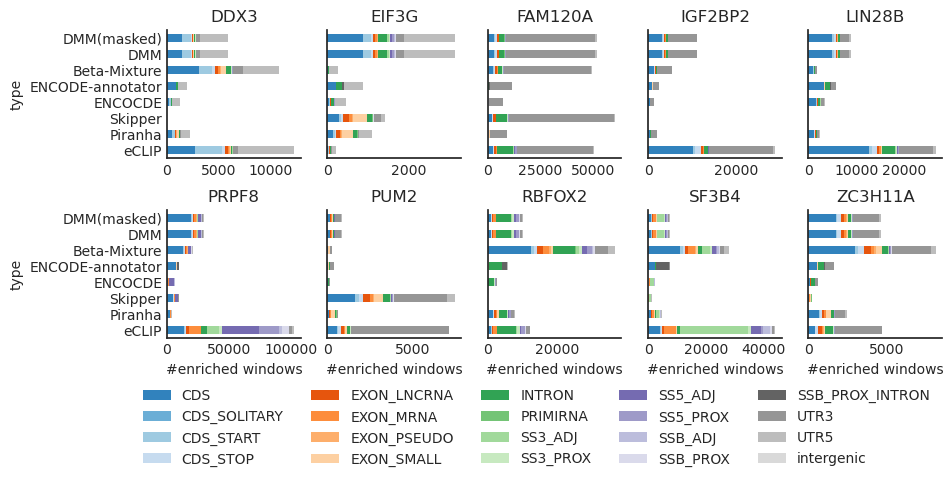

In [72]:
sns.set_palette('tab20c')
plt.style.use('seaborn-white')
skipper_counts['type'] = 'Skipper'
enrich_type_count['type'] = 'Beta-Mixture'
clipper_counts['type'] = 'ENCOCDE'
clipper_annotator_count['type'] = 'ENCODE-annotator'
eclip_counts['type'] = 'eclip-reproducible-windows'
dmm_fcount['type']='DMM'
dmm_masked_fcount['type']='DMM(masked)' # change is minimal, only for PUM2
eclip_counts['type']='eCLIP'
prianha_count['type']='Piranha'
counts = pd.concat([eclip_counts, prianha_count, skipper_counts, clipper_counts, clipper_annotator_count, 
                    enrich_type_count,  dmm_fcount, dmm_masked_fcount], 
                   axis = 0).T.sort_index().T
counts.reset_index(inplace = True)

f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
axes = axes.flatten(order = 'C')
i = 0
for rbp, group in counts.groupby(by = 'index'):
    group.set_index('type').plot.barh(stacked = True, ax = axes[i], legend = False)
    axes[i].set_title(rbp)
    if i>=5:
        axes[i].set_xlabel('#enriched windows')
    i+=1
axes[-1].legend(bbox_to_anchor = (1, -0.3), ncol = 5)
sns.despine()
plt.tight_layout(pad = 1)
plt.subplots_adjust(
                    hspace=0.4)
plt.savefig(figdir/f'feature_bar.pdf')


In [73]:
counts_summary = pd.concat([counts.set_index(['index', 'type']).sum(axis = 1).unstack(),
           mapped_reads_n_cluster],
          axis = 1).sort_values(by = 'total_mapped_reads')

In [74]:
counts_summary.mean(axis = 0)

Beta-Mixture             16143.9
DMM                      13385.3
DMM(masked)              13385.3
ENCOCDE                   2561.8
ENCODE-annotator          4791.1
Piranha                   3627.6
Skipper                   8043.2
eCLIP                    28901.4
0                            0.4
total_mapped_reads    18096012.3
dtype: float64

In [75]:
qc = pd.read_csv(basedir/'QC/dup_level.csv', index_col = 0)
qc.loc[qc['dup_bam'].str.contains(out_stem)]

,dup_bam,rmdup_bam,before_dedup,after_dedup,percent unique fragment
30,K562_rep6/bams/IGF2BP2.Aligned.sortedByCoord.o...,K562_rep6/bams/IGF2BP2.rmDup.Aligned.sortedByC...,17787400,1022528,0.057486
31,K562_rep6/bams/RBFOX2.Aligned.sortedByCoord.ou...,K562_rep6/bams/RBFOX2.rmDup.Aligned.sortedByCo...,29030465,2125302,0.073209
32,K562_rep6/bams/PUM2.Aligned.sortedByCoord.out.bam,K562_rep6/bams/PUM2.rmDup.Aligned.sortedByCoor...,2126048,184106,0.086595
33,K562_rep6/bams/FAM120A.Aligned.sortedByCoord.o...,K562_rep6/bams/FAM120A.rmDup.Aligned.sortedByC...,35255242,3612869,0.102477
34,K562_rep6/bams/DDX3.Aligned.sortedByCoord.out.bam,K562_rep6/bams/DDX3.rmDup.Aligned.sortedByCoor...,14909476,612527,0.041083
35,K562_rep6/bams/ZC3H11A.Aligned.sortedByCoord.o...,K562_rep6/bams/ZC3H11A.rmDup.Aligned.sortedByC...,7640688,587172,0.076848
36,K562_rep6/bams/EIF3G.Aligned.sortedByCoord.out...,K562_rep6/bams/EIF3G.rmDup.Aligned.sortedByCoo...,4472042,288050,0.064411
37,K562_rep6/bams/PRPF8.Aligned.sortedByCoord.out...,K562_rep6/bams/PRPF8.rmDup.Aligned.sortedByCoo...,22036578,1351065,0.061310
38,K562_rep6/bams/LIN28B.Aligned.sortedByCoord.ou...,K562_rep6/bams/LIN28B.rmDup.Aligned.sortedByCo...,9156087,763337,0.083369
39,K562_rep6/bams/SF3B4.Aligned.sortedByCoord.out...,K562_rep6/bams/SF3B4.rmDup.Aligned.sortedByCoo...,38546097,1120841,0.029078


/tmp/ipykernel_1374035/3105478402.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_1374035/3105478402.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad = 1)


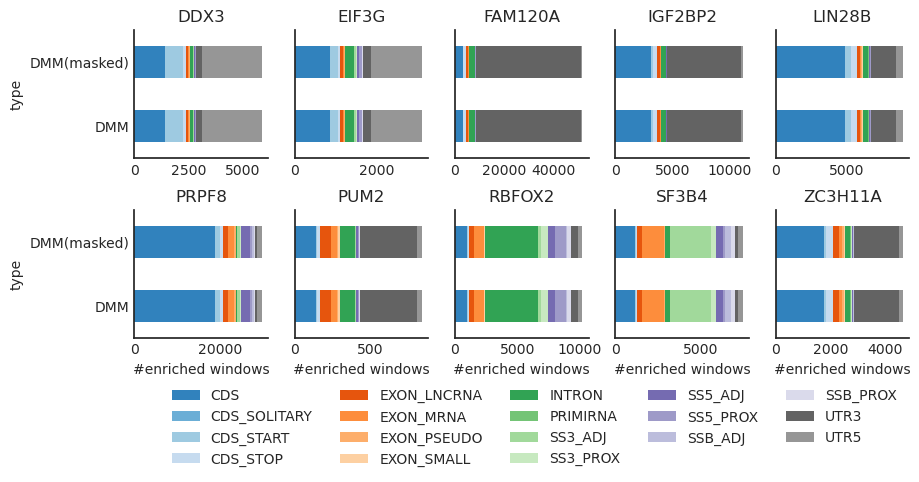

In [76]:
sns.set_palette('tab20c')
plt.style.use('seaborn-white')
skipper_counts['type'] = 'Skipper'
enrich_type_count['type'] = 'Beta-Mixture'
clipper_counts['type'] = 'ENCODE'
clipper_annotator_count['type'] = 'ENCODE-annotator'
eclip_counts['type'] = 'eclip-reproducible-windows'
dmm_fcount['type']='DMM'
dmm_masked_fcount['type']='DMM(masked)' # change is minimal, only for PUM2
eclip_counts['type']='eCLIP'
prianha_count['type']='Piranha'
counts = pd.concat([dmm_fcount, dmm_masked_fcount], 
                   axis = 0).T.sort_index().T
counts.reset_index(inplace = True)

f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
axes = axes.flatten(order = 'C')
i = 0
for rbp, group in counts.groupby(by = 'index'):
    group.set_index('type').plot.barh(stacked = True, ax = axes[i], legend = False)
    axes[i].set_title(rbp)
    if i>=5:
        axes[i].set_xlabel('#enriched windows')
    i+=1
axes[-1].legend(bbox_to_anchor = (1, -0.3), ncol = 5)
sns.despine()
plt.tight_layout(pad = 1)
plt.subplots_adjust(
                    hspace=0.4)
plt.savefig(figdir/f'feature_bar.pdf')


# Sensitivity

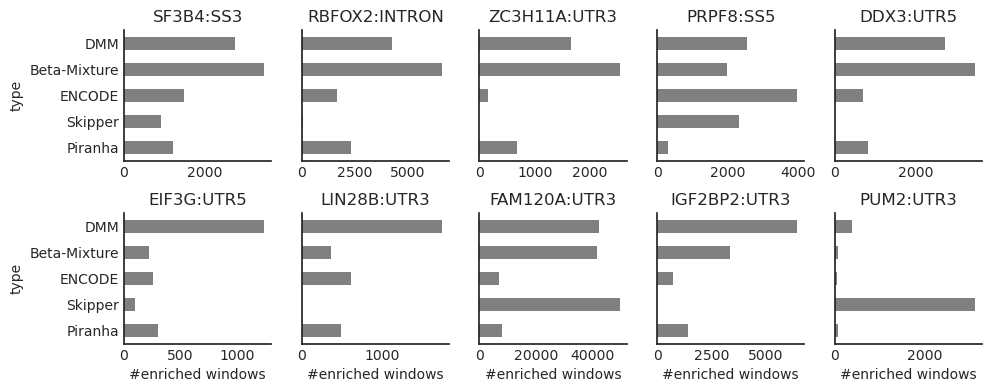

In [77]:
# ascertained feature

counts = pd.concat([prianha_count, skipper_counts, clipper_counts, 
                    enrich_type_count, dmm_fcount], 
                   axis = 0).T.sort_index().T
counts.reset_index(inplace = True)

f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
axes = axes.flatten()

feature = {'SF3B4': 'SS3', 
           'IGF2BP2': 'UTR3', 
           'RBFOX2': 'INTRON', 
           'EIF3G': 'UTR5', 
           'FAM120A': 'UTR3', 
           'DDX3': 'UTR5', 
           'LIN28B': 'UTR3',
           'PUM2': 'UTR3', 
           'PRPF8': 'SS5', 
           'ZC3H11A': 'UTR3'
          }
truth_count = []
for i, (rbp, ax) in enumerate(zip(counts['index'].unique(), axes)):
    feat = feature[rbp]
    presumed_truth = counts.loc[counts['index']==rbp].set_index('type')[counts.columns[counts.columns.str.contains(feat)]
                                                      ].sum(axis = 1)
    presumed_truth.plot.barh(ax = ax, color = 'Grey')
    ax.set_title(f'{rbp}:{feat}')
    if i>=5:
        ax.set_xlabel('#enriched windows')
    i+=1
    
    presumed_truth.name = rbp
    truth_count.append(presumed_truth)
truth_count = pd.concat(truth_count, axis = 1)
sns.despine()
plt.tight_layout(pad = 1)
plt.subplots_adjust(
                    hspace=0.4)
plt.savefig(figdir/f'Ascertained_feature.pdf')

In [78]:
(truth_count.T['DMM']/truth_count.T['ENCODE']).mean()

4.943519598109471

In [79]:
(truth_count.T['Beta-Mixture']/truth_count.T['ENCODE']).mean()

4.172090102979628

In [80]:
megaoutput.loc[megaoutput[f'{out_stem}.RBFOX2']].index.isin(ground_truth_skipper.loc[ground_truth_skipper['RBFOX2']].index).mean()

0.29642716921868867

# Motifs

In [81]:

window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name'].isin(
    ['1-TGCATG', '2-GCATST', '3-AGCATG','8-TGCACA', '9-TGCACG']                                                            
)
]
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [82]:
def read_everything(rbp):
    beta = pd.read_csv(basedir / 'beta-mixture_CC'/f'{out_stem}.{rbp}.enriched_windows.tsv', sep = '\t')
    prianha =pd.read_csv( basedir / 'comparison' / 'piranha' / 'CC'/f'{out_stem}.{rbp}.bed',
                         names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'],
                         sep = '\t')
    skipper = pd.read_csv(basedir / 'skipper_CC'/'enriched_windows'/f'{out_stem}.{rbp}.enriched_windows.tsv.gz',
                          sep = '\t')
    return beta, prianha, skipper
    

In [83]:
b,p,s = read_everything('PUM2')
motif_df = pum_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt = pd.concat([dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']

In [84]:
b,p,s = read_everything('RBFOX2')
motif_df = rbfox2_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt_fox2 = pd.concat([
    dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt_fox2.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']


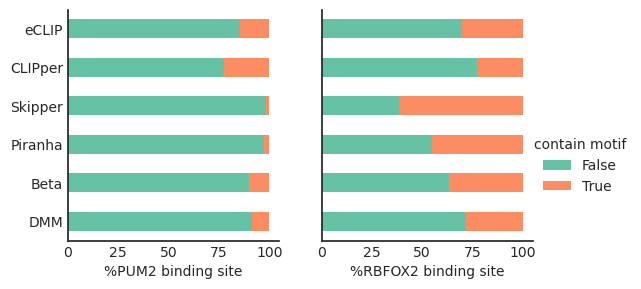

In [86]:
f, ax = plt.subplots(1,2, sharey = True, figsize = (6,3))
(100*(motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[0], legend = False)
(100*(motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[1])
ax[0].set_xlabel('%PUM2 binding site')
ax[1].set_xlabel('%RBFOX2 binding site')
ax[1].legend(bbox_to_anchor = (1.5, 0.5), title = 'contain motif')
sns.despine()
plt.savefig(figdir/f'PUM2_RBFOX2_precmotif.pdf')

In [87]:
motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.913507,0.901575,0.972136,0.983833,0.774194,0.854624
True,0.086493,0.098425,0.027864,0.016167,0.225806,0.145376


In [88]:
motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.718009,0.633354,0.550006,0.385417,0.774194,0.696096
True,0.281991,0.366646,0.449994,0.614583,0.225806,0.303904


In [89]:
def single_rbp_auprc_motif(col, truth, mixture_score_by_rbp, data, 
                 clipper_pv = clipper_pv, clipper_fc = clipper_fc, beta_score = beta_score):
    # common index
    com_index = list(set(ground_truth_skipper.index).intersection(set(data.index)))
    # plot ROC curve
    f, ax = plt.subplots(1,1, figsize = (4,4), 
                           sharex = True, sharey = True)
    
    
    
    # DMM
    truth = truth.loc[com_index]
    score = mixture_score_by_rbp.loc[com_index, col]
    
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'DMM AUPRC={auprc:.2f}')
    

    # Beta
    beta_s = beta_score.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            beta_s)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'Beta-Mixture AUPRC={auprc:.2f}')
    

    # CLIPper p-value
    pv_score = clipper_pv.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            pv_score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'CLIPper(p-value) AUPRC={auprc:.2f}')
    

    # CLIPper p-value
    fc_score = clipper_fc.loc[com_index, col]
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            fc_score)
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'CLIPper(FC), AUPRC={auprc:.2f}')
    



    ax.set_title(col)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    ax.legend(bbox_to_anchor = (0.5, 1))
    sns.despine()

In [90]:
by_rbp.head()

,IGF2BP2,RBFOX2,PUM2,FAM120A,DDX3,ZC3H11A,EIF3G,PRPF8,LIN28B,SF3B4
Row.names,,,,,,,,,,
1,0.000068,0.000001,0.999721,0.000013,0.000004,0.999872,3.321881e-08,0.000045,0.000002,8.029009e-06
10,0.252601,0.002509,0.207966,0.380835,0.102666,0.205040,1.160439e-02,0.469136,0.012982,2.607222e-02
100013,0.066231,0.000129,0.006537,0.999999,0.000004,0.000189,1.335691e-09,0.000005,0.004329,9.693770e-10
100014,0.101109,0.005947,0.031488,0.999942,0.000395,0.008281,9.191610e-07,0.000235,0.011267,1.927438e-07
100015,0.134219,0.000348,0.014822,0.999999,0.000012,0.000542,1.616678e-09,0.000020,0.006289,5.450232e-09


In [91]:
pum_motif_binary = pd.Series(by_rbp.index.isin(pum_motif['PositionID']), index = by_rbp.index)
rbfox2_motif_binary = pd.Series(by_rbp.index.isin(rbfox2_motif['PositionID']), index = by_rbp.index)

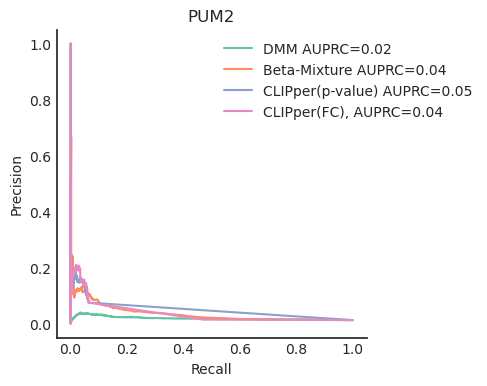

In [92]:
single_rbp_auprc_motif('PUM2', pum_motif_binary, by_rbp, data)
plt.savefig(figdir/f'PUM2_motif_AUPRC.pdf')

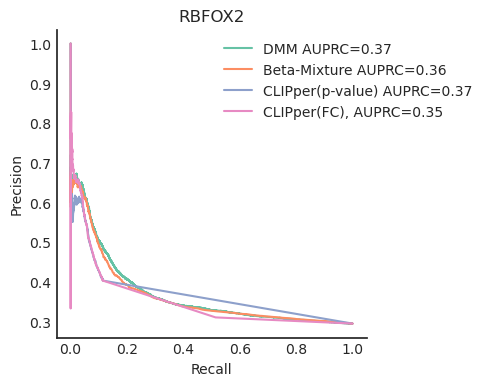

In [93]:
single_rbp_auprc_motif('RBFOX2', rbfox2_motif_binary, by_rbp, data)
plt.savefig(figdir/f'RBFOX2_motif_AUPRC.pdf')

In [94]:
def accuracy_among_topk(score, truth, k):
    indicies = score.sort_values(ascending = False).iloc[:k].index
    return truth.loc[indicies].mean()
def single_rbp_topk(col, truth, mixture_score_by_rbp, data, 
                 clipper_pv = clipper_pv, clipper_fc = clipper_fc, beta_score = beta_score):
    
    
    # common index
    com_index = list(set(ground_truth_skipper.index).intersection(set(data.index)))
    # plot ROC curve
    f, ax = plt.subplots(1,1, figsize = (4,4), 
                           sharex = True, sharey = True)
    
    stat = []
    for k in [10,100,1000,10000]:
        # DMM
        truth = truth.loc[com_index]
        score = mixture_score_by_rbp.loc[com_index, col]

        dmm_topk = accuracy_among_topk(score, truth, k)



        # Beta
        beta_s = beta_score.loc[com_index, col]
        beta_topk =  accuracy_among_topk(beta_s, truth, k)
        

        # CLIPper p-value
        pv_score = clipper_pv.loc[com_index, col]
        clipperp_topk =  accuracy_among_topk(pv_score, truth, k)

        # CLIPper p-value
        fc_score = clipper_fc.loc[com_index, col]
        clipperfc_topk = accuracy_among_topk(fc_score, truth, k)
        
        stat.append([k, dmm_topk, beta_topk, clipperp_topk, clipperfc_topk])
        
    stat = pd.DataFrame(stat, columns = ['k', 'DMM', 'BBM', 'CLIPper p-value', 'CLIPper FC']
                                         ).set_index('k')
    stat.plot.bar(ax = ax)
    ax.set_title(col)
    ax.set_ylabel('Top k Accuracy')
    ax.set_xlabel('k')
    ax.legend(loc='upper right')
    sns.despine()
    
    return stat
    


In [95]:
seq = pd.read_csv('/tscc/nfs/home/hsher/ps-yeolab5/ABC_DL/HEK293_rep1.DDX3.tsv', sep = '\t', 
                 names = ['chrom', 'name', 'seq', 'struct', 'label', '-'])


In [96]:
seq

,chrom,name,seq,struct,label,-
0,chr1,1,ATTAATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAG...,"-1.0,-1.0,-1.0,-1.0,-1.0,0.4,0.4,0.1,0.2,0.3,0...",-1,629639
1,chr1,10,CACCCTCCTTAACCTCTACTTCTACCTGCGCCTAATCTACTCCACC...,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...",-1,630493
2,chr1,1000,ATGAGTTCGGCGCCGGCCTCAGGCTCCGTGCGCGCGCGCTATCTTG...,"0.5,1.0,0.5,0.9,0.4,1.0,0.4,0.1,0.3,0.0,0.0,0....",1,1308643
3,chr1,1001,GTAGGTTTCCCAGGCGCAGCGGCGGGCGCCACGTGGGCCCGGGCGG...,NaN,-1,1308720
4,chr2,1001139,GTCTACAGCCATACCACCCTGAACACGCCCGATCTCGTCTGATCGT...,NaN,-1,188276787
...,...,...,...,...,...,...
173124,chr1,99985,AGTTAAATATTTGAGATCATATGTTAATTAGTGTAATCATTCCACC...,NaN,-1,65432826
173125,chr1,99986,TTGTCAATATATAATCAAAATAAAAAACAAAACATACTCTCTCCCC...,NaN,-1,65432925
173126,chr1,99987,TGGGGGAAGAGCTCCACTGAGATGCGGGCAGGGAGGCTGGGCTCGA...,NaN,-1,65433025
173127,chr1,99988,TTCCTTTATGATCTGGCACTTCTCCCCAGCTCCTTCCCTCTGCCCC...,NaN,-1,65433124


In [97]:
megaoutput.sort_values(by = f'logLR:{out_stem}.RBFOX2', ascending = False).iloc[:10][[
'gene_name', 'strand']]

,gene_name,strand
Row.names,,
4973884,TBCD,+
5569417,PTTG1IP,-
5680848,C22orf34,-
4973887,TBCD,+
5680847,C22orf34,-
5444137,RTEL1,+
5649095,PRAME,-
4973888,TBCD,+
3570158,CCDC88B,+


In [98]:
seq.loc[seq['name'].isin(megaoutput.sort_values(by = f'logLR:{out_stem}.RBFOX2', ascending = False).iloc[:10]['name'])]

,chrom,name,seq,struct,label,-
70833,chr11,3570158,CACTTCCCTTCTCTGACCTCCTCCCTGCAGGAGCCTCAGCCCCCCC...,NaN,-1,64354893
108360,chr16,4759537,GCTGCATGGCTGGGAGGGTCCCCGGTGCTGCATGGCTGGGAGGGTC...,NaN,-1,1387069
119784,chr17,4973884,GTTGTTGTTGGCTGTGCTGTTGTTGGCTGTGCTGTTGTTGCCTGTG...,NaN,-1,82850126
119787,chr17,4973887,GTGCTGTTGTTGGCTGTGCTGTTTTGCTGTTGGCTGTGCTGTTGTT...,NaN,-1,82850426
119788,chr17,4973888,GTGCTGTTGTTAGCTGTGCTGTTGTTGGCTGTGCTGTTGTTGGCTG...,NaN,-1,82850526
144793,chr20,5444137,CTCCCAGTGTGTGCCCAGCCCCACTCCCTTCCGCCCCGTGTGCCCA...,NaN,-1,63668053
149721,chr21,5569417,TCTGCTGCTGAGGCCGTGGTGGGCTGTGTCTCTGCTGCTGAGGCCG...,NaN,-1,44863117


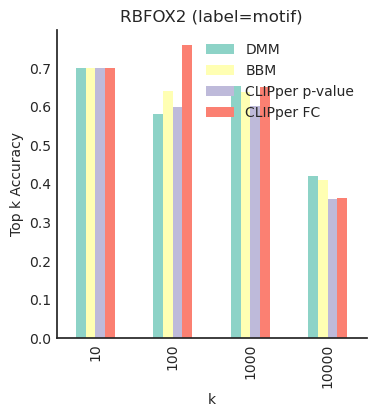

In [111]:
sns.set_palette('Set3')
stat = single_rbp_topk('RBFOX2', rbfox2_motif_binary, by_rbp, data)
plt.title('RBFOX2 (label=motif)')
plt.savefig(figdir / 'topk_RBFOX2_motif.pdf')

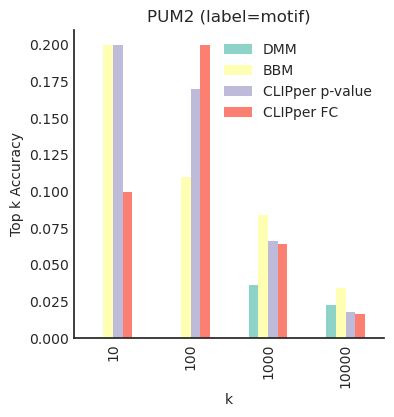

In [112]:
single_rbp_topk('PUM2', pum_motif_binary, by_rbp, data)
plt.title('PUM2 (label=motif)')
plt.savefig(figdir / 'topk_PUM2_motif.pdf')

# Shared binding site

In [102]:
# calculate jaccard index
def compute_jaccard_index(identity_tbl):
    ''' use jaccard index to show how much binding site overlapped between RBPs'''
    d_condense = pdist(identity_tbl.T, 'jaccard')
    d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
    return d


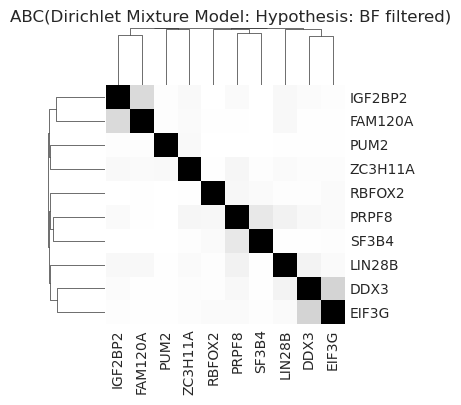

In [103]:
d_dmm = compute_jaccard_index(megaoutput[anno.columns])
d_dmm.index = [i.split('.')[1] for i in d_dmm.index]
d_dmm.columns = [i.split('.')[1] for i in d_dmm.columns]
cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
            vmax = 0.3)
cm.cax.set_visible(False)
plt.suptitle('ABC(Dirichlet Mixture Model: Hypothesis: BF filtered)', y = 1)
plt.savefig(figdir/f'DMM_jaccard.pdf')

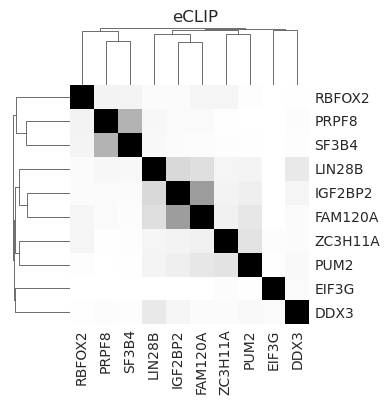

In [104]:
d_dmm = compute_jaccard_index(ground_truth_skipper)

cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
            vmax = 0.3)
cm.cax.set_visible(False)
plt.suptitle('eCLIP', y = 1)
plt.savefig(figdir/f'eCLIP_jaccard.pdf')

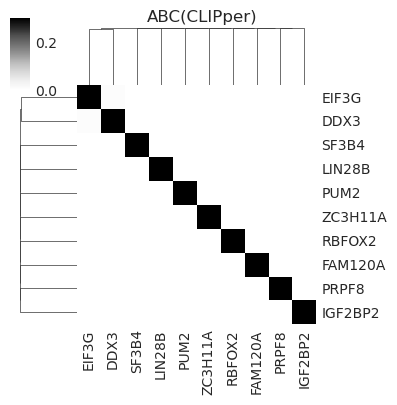

In [105]:
d_dmm = compute_jaccard_index(ground_truth)

cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
            vmax = 0.3)
plt.suptitle('ABC(CLIPper)', y = 1)
plt.savefig(figdir/f'ABC_CLIPper_jaccard.pdf')

# Show number of shared binding sites found

In [106]:
pair = ['SF3B4', 'PRPF8']

def plot_pairs(pair, ax, legend = False):
    clipper_1rep = pd.read_csv('Dan_multiplex1_K562_rep6.window.csv')
    eclip_counts = window_df.loc[window_df['name'].isin(ground_truth_skipper.loc[ground_truth_skipper[pair].all(axis = 1)].index),
                 'feature_type_top'].value_counts()
    eclip_counts.name = 'eCLIP'
    clipper_counts = window_df.loc[window_df['name'].isin(clipper_1rep.loc[clipper_1rep[pair].all(axis = 1)].index),
                'feature_type_top'].value_counts()
    clipper_counts.name = 'CLIPper'
    dmm_counts = window_df.loc[window_df['name'].isin(megaoutput.loc[megaoutput[[f'{out_stem}.{r}' for r in pair]].all(axis = 1)].index),
                'feature_type_top'].value_counts()   
    dmm_counts.name = 'DMM'

    is_piranha = piranha_pv[[c.split('.')[1] for c in anno.columns]].ge(0.95)
    prianha_counts = window_df.loc[window_df['name'].isin(
        is_piranha.loc[is_piranha[pair].all(axis = 1)].index),
                                   'feature_type_top'].value_counts()

    prianha_counts.name = 'Piranha'

    is_beta = beta_score[[c.split('.')[1] for c in anno.columns]].ge(2)
    beta_counts = window_df.loc[window_df['name'].isin(
        is_beta.loc[is_beta[pair].all(axis = 1)].index),
                                   'feature_type_top'].value_counts()

    beta_counts.name = 'BBM+CC'

    sns.set_palette('tab20c')
    pd.concat([dmm_counts, beta_counts, clipper_counts, prianha_counts, eclip_counts], axis = 1
             ).fillna(0).sort_index().T.plot.bar(stacked = True, ax = ax, legend = legend)
    
    sns.despine()
    ax.set_title('+'.join(pair))
    if legend:
        ax.legend(bbox_to_anchor = (1.5, 1))

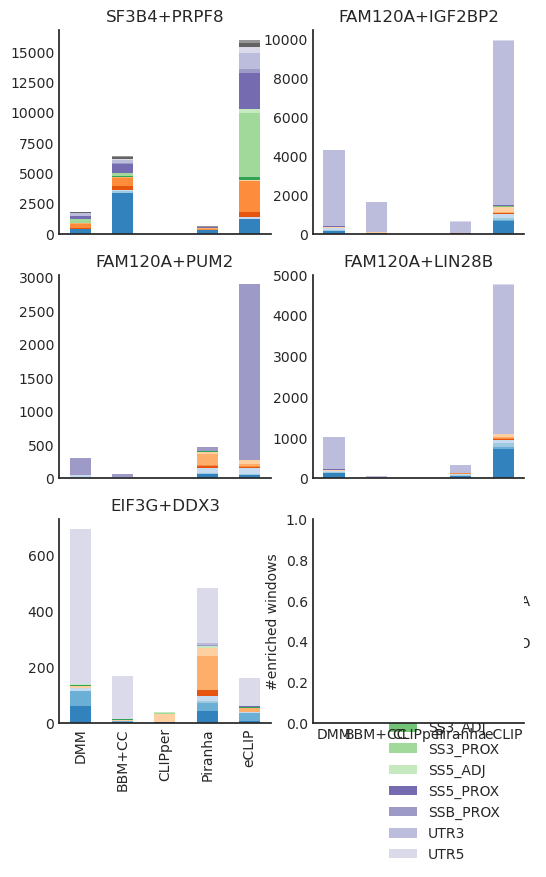

In [107]:
f, axes = plt.subplots(3,2, figsize = (6,9), sharex = True)
axes = axes.flatten()
plot_pairs(['SF3B4', 'PRPF8'], ax = axes[0])
plt.ylabel('#enriched windows')
plot_pairs(['FAM120A', 'IGF2BP2'], ax = axes[1])
plot_pairs(['FAM120A', 'PUM2'], ax = axes[2])
plt.ylabel('#enriched windows')
plot_pairs(['FAM120A', 'LIN28B'], ax = axes[3])
plot_pairs(['EIF3G', 'DDX3'], ax = axes[4], legend = True)
plt.ylabel('#enriched windows')
plt.savefig(figdir/f'n_shared.pdf')

In [108]:
ground_truth.loc[ground_truth[pair].all(axis = 1)].shape

(0, 10)

In [109]:
 piranha_pv

,SF3B4,RBFOX2,ZC3H11A,PRPF8,DDX3,EIF3G,LIN28B,FAM120A,IGF2BP2,PUM2,cluster
Row.names,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.998999,0.0,0.999819,0.0,0.99988,V12
10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V8
100013,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V10
100014,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V5
100015,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V1
...,...,...,...,...,...,...,...,...,...,...,...
99990,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V3
99991,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V3
99992,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,V2


In [110]:
anno.columns

Index(['K562_rep6.IGF2BP2', 'K562_rep6.RBFOX2', 'K562_rep6.PUM2',
       'K562_rep6.FAM120A', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A',
       'K562_rep6.EIF3G', 'K562_rep6.PRPF8', 'K562_rep6.LIN28B',
       'K562_rep6.SF3B4'],
      dtype='object')